<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [149]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [150]:
from bs4 import BeautifulSoup
import requests

##### Your Code Here #####
def clean_description(desc):
    soup = BeautifulSoup(desc).prettify()
    soup = BeautifulSoup(soup)
    return soup.get_text(" ").replace("\\n","").replace("\n","")
                
df = pd.read_csv("data/job_listings.csv")
df['clean_desc'] = df['description'].apply(clean_description)
ds_listings = df[df['title'].str.lower().str.contains("data scientist")].copy()

In [151]:
ds_listings['clean_desc'].iloc[0]

'b"    Job Requirements:         Conceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them                Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)                Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R                Ability to communicate Model findings to both Technical and Non-Technical stake holders                Hands on experience in SQL/Hive or similar programming language                Must show past work via GitHub, Kaggle or any other published article                Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.                   Apply Now               "'

## 2) Use Spacy to tokenize the listings 

In [152]:
##### Your Code Here #####
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [153]:
STOP_WORDS = nlp.Defaults.stop_words.union(["data"])

In [154]:
tokens = []
for doc in tokenizer.pipe(ds_listings['clean_desc'], batch_size=500):
    doc_tokens = []
    for token in doc:
        if (token.text.lower() not in STOP_WORDS):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
ds_listings['tokens'] = tokens

In [155]:
def get_lemmas(text):
    lemmas = []
    text = " ".join(text)
    doc = nlp(text)
    
    for token in doc:
        if ((token.is_stop == False) and (token.is_punct == False) and (token.pos_ != 'PRON')):
            lemmas.append(token.lemma_)
    return lemmas

In [156]:
ds_listings['lemmas'] = ds_listings['tokens'].apply(get_lemmas)

In [160]:
ds_listings['lemmas'].head()

0    [b,     , job, requirement,          , concept...
1    [b,   , job, description,           , scientis...
2    [b,     , scientist, work, consulting, busines...
3    [b,       , $, 4,969, $, 6,756, month,        ...
4    [b,     , location, usa, \xe2\x80\x93, multipl...
Name: lemmas, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [169]:
##### Your Code Here #####
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

all_lemmas = [" ".join(sublist) for sublist in ds_listings['lemmas'].tolist()]
vect.fit(all_lemmas)
dtm = vect.transform(all_lemmas)

In [215]:
word_count = {'words':[],'counts':[]}
for i in vect.vocabulary_:
    word_count['words'].append(i)
    word_count['counts'].append(vect.vocabulary_[i])


In [218]:
wc = pd.DataFrame(word_count)
wc

,words,counts
0,job,3299
1,requirement,4987
2,conceptual,1347
3,understand,6133
4,machine,3590
...,...,...
6628,applicants,521
6629,obligate,4088
6630,immunization,3014
6631,flu,2473


## 4) Visualize the most common word counts

In [226]:
from collections import Counter

In [227]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [208]:
##### Your Code Here #####
import squarify
import matplotlib.pyplot as plt

In [228]:
wc = count(ds_listings['lemmas'])

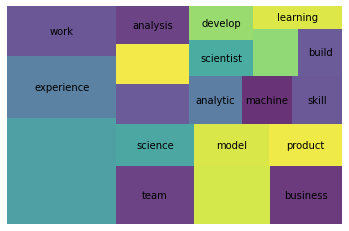

In [229]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [230]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [263]:
##### Your Code Here #####
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.95,
                        min_df=5,
                        tokenizer=tokenize)
data = [" ".join(row) for row in ds_listings['lemmas']]
dtm = tfidf.fit_transform(data)
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
dtm.head()

,,$,0,1,10,2,3,4,401(k,401k,...,you\'ll,you\'ll,you\xe2\x80\x99ll,you\xe2\x80\x99ll,you\xe2\x80\x99ll need,you\xe2\x80\x99ll work,you\xe2\x80\x99re,you\xe2\x80\x99re look,you\xe2\x80\x99ve,|
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.047388,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.075858,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.147984,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [264]:
dtm.shape

(406, 5923)

## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [266]:
##### Your Code Here #####
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [270]:
new = tfidf.transform(["python data"])
nn.kneighbors(new.todense())

(array([[1.35378321, 1.36045804, 1.36045804, 1.36045804, 1.36371803]]),
 array([[350,  99, 376, 230,  95]]))

In [271]:
data[350]

'b                  science encompass computational statistical skill require use support scientific enquiry sound business decision making look hire candidate work challenge science problem oil gas business include exploration production refining chemical retail corporate service                               job role responsibility                     apply statistical analysis pattern recognition machine learn \\xe2\\x80\\x93 domain knowledge subject specific model \\xe2\\x80\\x93 solve science engineering commercial problem                                 contribute stage science decision modeling project include problem formulation solution development product deployment                      translate business relevant scientific engineering commercial problem question address science                                         design experiment and/or run simulation generate new support analytic study                                         retrieve combine database historian and/or 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 